In [1]:
import smps
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
import os
import itertools

import matplotlib as mpl

In [2]:
# Initialize an empty DataFrame
df_lcs = pd.DataFrame()

# Define the start and end months and years
start_month = 11
start_year = 2023
end_month = 2
end_year = 2024

# Function to generate month-year strings
def generate_month_year_strings(start_month, start_year, end_month, end_year):
    month_year_list = []
    year = start_year
    month = start_month
    while year < end_year or (year == end_year and month <= end_month):
        month_year_list.append(f"{year}_{str(month).zfill(2)}")
        month += 1
        if month > 12:
            month = 1
            year += 1
    return month_year_list

# Generate the list of month-year strings
month_year_strings = generate_month_year_strings(start_month, start_year, end_month, end_year)

# Loop through each month-year string and load the CSV files
for month_year_string in month_year_strings:
    year, month = month_year_string.split('_')
    filename_tail = f"@devnode_{year}-{month}.csv"
    directory = os.path.join("lcs_data", month_year_string)

    df_co = pd.read_csv(os.path.join(directory, f"raw_CO-B4{filename_tail}"), sep=',')
    df_smps_opcn3 = pd.read_csv(os.path.join(directory, f"raw_OPC-N3{filename_tail}"), sep=',')
    df_pm_opcn3 = pd.read_csv(os.path.join(directory, f"raw_PM-OPCN3{filename_tail}"), sep=',')
    df_pm_sps30 = pd.read_csv(os.path.join(directory, f"raw_PM-SPS30{filename_tail}"), sep=',')
    df_trh = pd.read_csv(os.path.join(directory, f"raw_T_RH_P_BME280{filename_tail}"), sep=',')
 
    # Combining all datasets using the "Čas" column
    df_temp = pd.merge(df_co, df_trh, on="Čas")
    df_temp = pd.merge(df_temp, df_smps_opcn3, on="Čas")
    df_temp = pd.merge(df_temp, df_pm_opcn3, on="Čas")
    df_temp = pd.merge(df_temp, df_pm_sps30, on="Čas")
    
    # Calculating actual values for the WE (working electrode) and AE (auxiliary electrode) values
    df_temp["CO"] = df_temp["WE_CO"] - df_temp["AE_CO"]
      
    # Dropping the extra columns (including the pressure - that makes a negligible difference)
    df_temp = df_temp.drop(["WE_CO", "AE_CO", "PM_4"], axis=1)
    
    # Renaming the "Čas" column
    df_temp = df_temp.rename(columns={'Čas': 'Time'})
    
    # Converting the time to a datetime
    df_temp['Time'] = pd.to_datetime(df_temp['Time'])
    
    # 1h shift of the CSV data (CSV seems to be UTC+1, reference data UTC)
    df_temp['Time'] += pd.Timedelta(hours=1)
    
    # Set 'Time' column as the DataFrame index
    df_temp.set_index('Time', inplace=True)
    
    # Resample to 1-hour intervals and calculate the mean for each group
    df_temp_1h = df_temp.resample('1h').mean()
    
    # Assign the calculated hourly means back to the original DataFrame
    df_temp = df_temp_1h.reset_index()
    
    # Append the data to the main DataFrame
    df_lcs = pd.concat([df_lcs, df_temp], ignore_index=True)

# Renaming the "Time" column to "GMT"
df_lcs = df_lcs.rename(columns={'Time': 'GMT'})

# Set 'GMT' column as the DataFrame index
df_lcs.set_index('GMT', inplace=True)

# Print the data types of the final DataFrame
print(df_lcs.dtypes)

T          float64
RH         float64
p          float64
bin0       float64
bin1       float64
bin2       float64
bin3       float64
bin4       float64
bin5       float64
bin6       float64
bin7       float64
bin8       float64
bin9       float64
bin10      float64
bin11      float64
bin12      float64
bin13      float64
bin14      float64
bin15      float64
bin16      float64
bin17      float64
bin18      float64
bin19      float64
bin20      float64
bin21      float64
bin22      float64
bin23      float64
PM_1_x     float64
PM_2.5     float64
PM_10_x    float64
PM_1_y     float64
PM_2       float64
PM_10_y    float64
CO         float64
dtype: object


In [3]:
# The edited dataset has the "Celkem" values at the end of the data removed
#df_ref = pd.read_excel(month_year_string + "/MS_MarianskeHory_60min_" + month_year_string + "_edited.xlsx")
df_ref = pd.DataFrame()

df_ref = pd.read_csv('gmt_data/Nov-Feb_GMT_MarHory.csv', sep=';')
#df_ref = pd.read_csv('gmt_data/Mar-Jul_GMT_MarHory.csv', sep=';')

#df_ref = df_ref.rename(columns={
#        'Unnamed: 0': 'Time',
#        'Celaskon; 1663_MarHory; WSPE [m/s]': 'WSPE [m/s]',
#        'Celaskon; 1663_MarHory; WDIR [deg]': 'WDIR [deg]',
#        'Celaskon; 1663_MarHory; HUMI [%]': 'HUMI [%]',
#        'Celaskon; 1663_MarHory; PRES [hPa]': 'PRES [hPa]',
#        'Celaskon; 1663_MarHory; TEMP [°C]': 'TEMP [°C]',
#        'Celaskon; 1663_MarHory; PM10 [ug/m3]': 'PM10 [µg/m3]',
#        'Celaskon; 1663_MarHory; O3 [ug/m3]': 'O3 [µg/m3]',
#        'Celaskon; 1663_MarHory; SO2 [ug/m3]': 'SO2 [µg/m3]',
#        'Celaskon; 1663_MarHory; NO [ug/m3]': 'NO [µg/m3]',
#        'Celaskon; 1663_MarHory; NO2 [ug/m3]': 'NO2 [µg/m3]',
#        'Celaskon; 1663_MarHory; CO [ug/m3]': 'CO [µg/m3]'
#})

#Apply the function to the entire column
df_ref['GMT'] = pd.to_datetime(df_ref['GMT'])

#Synchronizing the datatypes of "Time" in the datasets
df_ref['GMT'] = df_ref['GMT'].dt.tz_localize('UTC')

# Dropping the extra columns (including the pressure - that makes a negligible difference)
df_ref = df_ref.drop(["TIME"], axis=1)

# Pokud potřebujete změnit pouze určité sloupce, můžete specifikovat sloupce takto:

df_ref[['WDIR [deg]', 
        'HUMI [%]', 
        'PRES [hPa]', 
        'TEMP [°C]', 
        'PM10 [ug/m3]', 
        'PM25 [ug/m3]', 
        'PM01 [ug/m3]', 
        'O3 [ug/m3]', 
        'SO2 [ug/m3]', 
        'NO [ug/m3]', 
        'NO2 [ug/m3]', 
        'CO [ug/m3]']] = df_ref[['WDIR [deg]', 
                                 'HUMI [%]', 
                                 'PRES [hPa]', 
                                 'TEMP [°C]', 
                                 'PM10 [ug/m3]', 
                                 'PM25 [ug/m3]', 
                                 'PM01 [ug/m3]', 
                                 'O3 [ug/m3]', 
                                 'SO2 [ug/m3]', 
                                 'NO [ug/m3]', 
                                 'NO2 [ug/m3]', 
                                 'CO [ug/m3]']].astype('float64')

#df_ref.head()
#print(df_ref.describe())
print(df_ref.dtypes)

GMT             datetime64[ns, UTC]
WSPE [m/s]                  float64
WDIR [deg]                  float64
HUMI [%]                    float64
PRES [hPa]                  float64
TEMP [°C]                   float64
PM10 [ug/m3]                float64
PM25 [ug/m3]                float64
PM01 [ug/m3]                float64
O3 [ug/m3]                  float64
SO2 [ug/m3]                 float64
NO [ug/m3]                  float64
NO2 [ug/m3]                 float64
CO [ug/m3]                  float64
dtype: object


In [4]:
df_cams = pd.DataFrame()

df_cams = pd.read_csv('gmt_data/Nov-Feb_gmt_CAMS-EUR.csv', sep=';')
#df_cams = pd.read_csv('gmt_data/Mar-Jul_gmt_CAMS-EUR.csv', sep=';')

df_cams['GMT'] = pd.to_datetime(df_ref['GMT'])

#Synchronizing the datatypes of "Time" in the datasets
df_cams['GMT'] = df_cams['GMT'].dt.tz_convert('UTC')

# Dropping the extra columns (including the pressure - that makes a negligible difference)
df_cams = df_cams.drop(["gmt"], axis=1)

#df_ref.head()
#print(df_ref.describe())
print(df_cams.dtypes)

pm10 (μg/m³)                            float64
pm2_5 (μg/m³)                           float64
carbon_monoxide (μg/m³)                 float64
nitrogen_dioxide (μg/m³)                float64
sulphur_dioxide (μg/m³)                 float64
ozone (μg/m³)                           float64
dust (μg/m³)                            float64
uv_index ()                             float64
ammonia (μg/m³)                         float64
GMT                         datetime64[ns, UTC]
dtype: object


In [5]:
# Merge the two DataFrames on the 'Time' column
df = pd.merge(df_lcs, df_ref, on='GMT')
df = pd.merge(df, df_cams, on='GMT')
# Sorting the values by the "Time" attribute
df.sort_values(by="GMT")
# Check the correlation between 'CO' and 'CO [µg/m3]'
#correlation = df_merged['CO'].diff().corr(df_merged['CO [ug/m3]'].diff())
#print(f'Correlation between CO and CO [µg/m3]: {correlation}')

#df.head()
print(df.describe())
#print(df.dtypes)

                 T           RH            p         bin0         bin1  \
count  2778.000000  2778.000000  2778.000000  2778.000000  2778.000000   
mean      3.625455    78.765911   986.356590   869.100959   260.943143   
std       5.189808     9.341749    11.401738   805.386630   453.620727   
min     -18.100528    41.926049   958.952381    14.313889     1.841667   
25%       0.142611    72.961625   978.320139   226.378290    27.877083   
50%       4.062611    80.062847   986.000000   614.216667    73.520833   
75%       7.297924    85.532778   994.000000  1299.146528   261.192361   
max      18.182127    99.583889  1011.000000  4212.566667  3184.713889   

              bin2         bin3         bin4         bin5         bin6  ...  \
count  2778.000000  2778.000000  2778.000000  2778.000000  2778.000000  ...   
mean     77.378742    15.239325    13.138123     6.515718     2.602002  ...   
std     199.922744    55.763445    62.707640    38.794354    20.460773  ...   
min       0.54166

In [6]:
start_date = '2023-11-01'
end_date = '2024-07-08'

# Filter the DataFrame
sel_df = df[df['GMT'] >= start_date]
sel_df = sel_df[sel_df['GMT'] <= end_date]

# Sorting the values by the "GMT" attribute
df = sel_df.sort_values(by="GMT")

df["T"] = pd.to_numeric(df["T"], errors='coerce') + 273.15
df["CO"] = pd.to_numeric(df["CO"], errors='coerce') * 4394 + (-0.693)* pd.to_numeric(df["T"], errors='coerce')

#df.head()
print(df[['T',"CO",'HUMI [%]','PRES [hPa]']].describe())

                 T           CO     HUMI [%]   PRES [hPa]
count  2778.000000  2778.000000  2905.000000  2905.000000
mean    276.775455   240.678741    88.729432  1013.968675
std       5.189808   216.368878    11.542193    12.467619
min     255.049472    39.398028    39.000000   982.000000
25%     273.292611   110.632930    81.000000  1005.000000
50%     277.212611   165.170667    93.000000  1013.000000
75%     280.447924   274.418840    99.000000  1024.000000
max     291.332127  1726.430134    99.000000  1041.000000


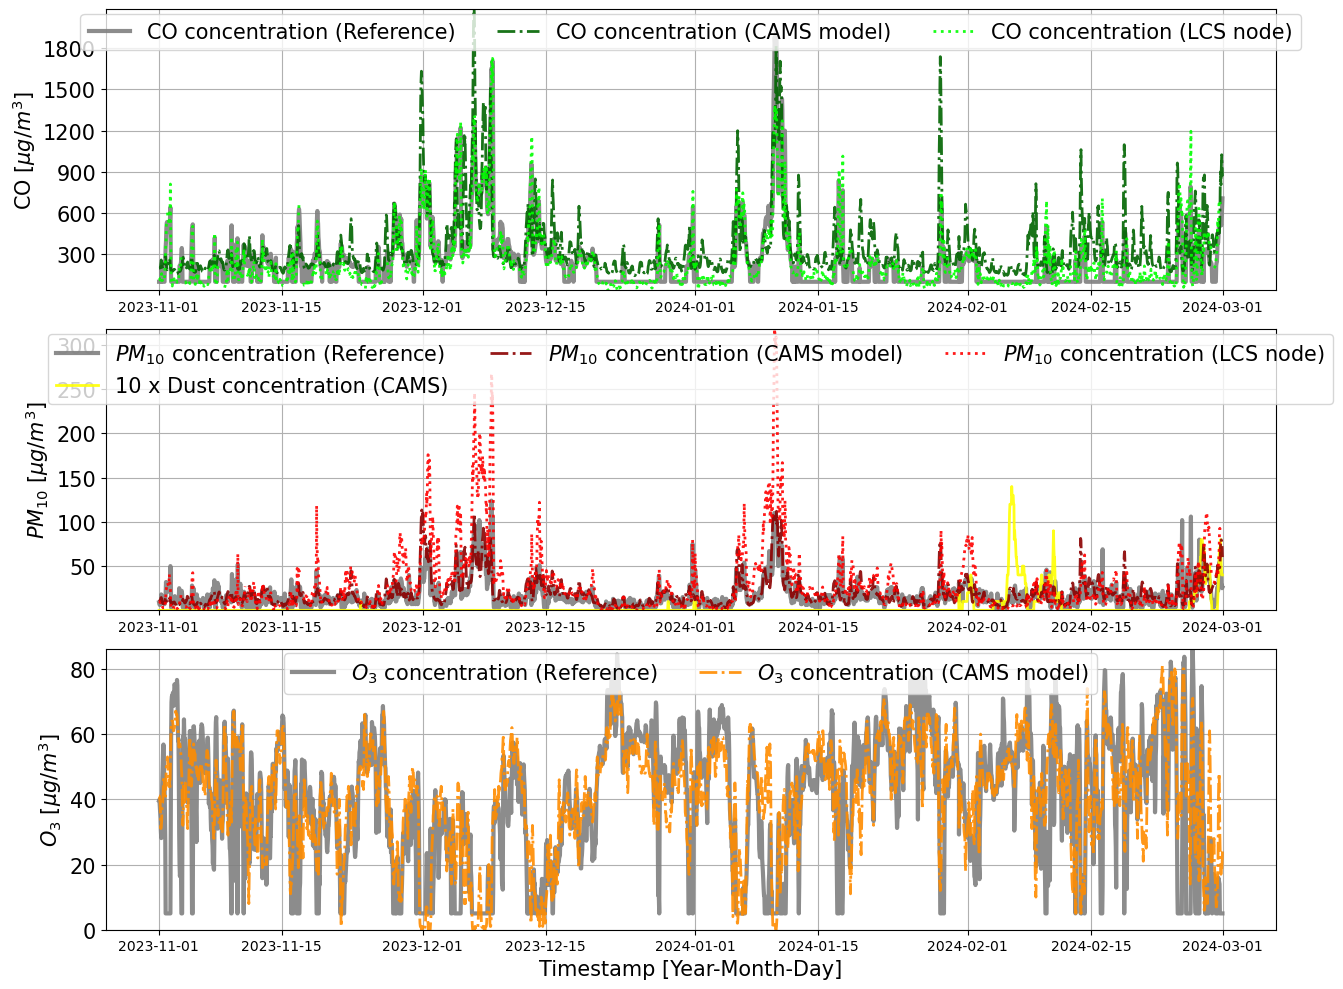

In [7]:
# Create a figure and a set of subplots with adjusted height
fig, axs = plt.subplots(3, 1, figsize=(14, 10))  # 4 rows, 1 column, reduced height

# Define the y-axis limits for CO
y_min = min(df['CO [ug/m3]'].min(), df['carbon_monoxide (μg/m³)'].min(), df['CO'].min())
y_max = max(df['CO [ug/m3]'].max(), df['carbon_monoxide (μg/m³)'].max(), df['CO'].max())

# First subplot
axs[0].plot(df['GMT'], df['CO [ug/m3]'], color="grey", linestyle="solid", linewidth=3, alpha=0.9, label='CO concentration (Reference)')
axs[0].plot(df['GMT'], df['carbon_monoxide (μg/m³)'], color="darkgreen", linestyle="dashdot", linewidth=2, alpha=0.9, label='CO concentration (CAMS model)')
axs[0].plot(df['GMT'], df['CO'], color="lime", linestyle="dotted", linewidth=2, alpha=0.9,  label='CO concentration (LCS node)')
axs[0].set_ylabel('CO [$µg/m^3$]', fontsize=15)
axs[0].grid(True)
axs[0].set_ylim(y_min, y_max)
axs[0].yaxis.set_major_locator(ticker.MultipleLocator(300))  # Adjust interval as needed
axs[0].tick_params(axis='y', labelsize=15)
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.02 * y_max / y_max), ncol=3, fontsize=15)

# Define the y-axis limits for PM10
y_min = min(df['PM10 [ug/m3]'].min(), df['pm10 (μg/m³)'].min(), df['PM_10_y'].min())
y_max = max(df['PM10 [ug/m3]'].max(), df['pm10 (μg/m³)'].max(), df['PM_10_y'].max())

# Second subplot
axs[1].plot(df['GMT'], df['PM10 [ug/m3]'], color="grey", linestyle="solid", linewidth=3, alpha=0.9, label='$PM_{10}$ concentration (Reference)')
axs[1].plot(df['GMT'], df['dust (μg/m³)']*10, color="yellow", linestyle="solid", linewidth=2, alpha=0.9, label='10 x Dust concentration (CAMS)')
axs[1].plot(df['GMT'], df['pm10 (μg/m³)'], color="darkred", linestyle="dashdot", linewidth=2, alpha=0.9, label='$PM_{10}$ concentration (CAMS model)')
axs[1].plot(df['GMT'], df['PM_10_y'], color="red", linestyle="dotted", linewidth=2, alpha=0.9,  label='$PM_{10}$ concentration (LCS node)')
axs[1].set_ylabel('$PM_{10}$ [$µg/m^3$]', fontsize=15)
axs[1].grid(True)
axs[1].set_ylim(y_min, y_max)
axs[1].yaxis.set_major_locator(ticker.MultipleLocator(50))  # Adjust interval as needed
axs[1].tick_params(axis='y', labelsize=15)
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.02 * y_max / y_max), ncol=3, fontsize=15)

# Define the y-axis limits for O3
y_min = min(df['O3 [ug/m3]'].min(), df['ozone (μg/m³)'].min())
y_max = max(df['O3 [ug/m3]'].max(), df['ozone (μg/m³)'].max())

# Fourth subplot
axs[2].plot(df['GMT'], df['O3 [ug/m3]'], color="grey", linestyle="solid", linewidth=3, alpha=0.9, label='$O_3$ concentration (Reference)')
axs[2].plot(df['GMT'], df['ozone (μg/m³)'], color="darkorange", linestyle="dashdot", linewidth=2, alpha=0.9, label='$O_3$ concentration (CAMS model)')
axs[2].set_ylabel('$O_3$ [$µg/m^3$]', fontsize=15)
axs[2].set_xlabel('Timestamp [Year-Month-Day]', fontsize=15)
axs[2].grid(True)
axs[2].set_ylim(y_min, y_max)
axs[2].yaxis.set_major_locator(ticker.MultipleLocator(20))  # Adjust interval as needed
axs[2].tick_params(axis='y', labelsize=15)
axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, 1.02 * y_max / y_max), ncol=3, fontsize=15)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [8]:
print("Columns in DataFrame (df):", df.columns)

Columns in DataFrame (df): Index(['GMT', 'T', 'RH', 'p', 'bin0', 'bin1', 'bin2', 'bin3', 'bin4', 'bin5',
       'bin6', 'bin7', 'bin8', 'bin9', 'bin10', 'bin11', 'bin12', 'bin13',
       'bin14', 'bin15', 'bin16', 'bin17', 'bin18', 'bin19', 'bin20', 'bin21',
       'bin22', 'bin23', 'PM_1_x', 'PM_2.5', 'PM_10_x', 'PM_1_y', 'PM_2',
       'PM_10_y', 'CO', 'WSPE [m/s]', 'WDIR [deg]', 'HUMI [%]', 'PRES [hPa]',
       'TEMP [°C]', 'PM10 [ug/m3]', 'PM25 [ug/m3]', 'PM01 [ug/m3]',
       'O3 [ug/m3]', 'SO2 [ug/m3]', 'NO [ug/m3]', 'NO2 [ug/m3]', 'CO [ug/m3]',
       'pm10 (μg/m³)', 'pm2_5 (μg/m³)', 'carbon_monoxide (μg/m³)',
       'nitrogen_dioxide (μg/m³)', 'sulphur_dioxide (μg/m³)', 'ozone (μg/m³)',
       'dust (μg/m³)', 'uv_index ()', 'ammonia (μg/m³)'],
      dtype='object')


In [9]:
df['GMT'] = pd.to_datetime(df['GMT'])

# Nastavte sloupec GMT jako index
df.set_index('GMT', inplace=True)

# Zkontrolujte, zda je index správně nastaven
print(df.head())

                                    T         RH           p        bin0  \
GMT                                                                        
2023-11-01 01:00:00+00:00  282.570767  86.635767  983.170000  730.150000   
2023-11-01 02:00:00+00:00  282.422361  85.462083  984.000000  649.347222   
2023-11-01 03:00:00+00:00  282.087389  85.388028  984.000000  609.663889   
2023-11-01 04:00:00+00:00  281.681500  85.452583  984.000000  562.686111   
2023-11-01 05:00:00+00:00  281.390945  85.452805  984.236111  540.658333   

                                bin1      bin2      bin3      bin4      bin5  \
GMT                                                                            
2023-11-01 01:00:00+00:00  42.456667  7.103333  1.110000  1.320000  1.140000   
2023-11-01 02:00:00+00:00  35.383333  6.563889  1.069444  1.294444  0.941667   
2023-11-01 03:00:00+00:00  36.544444  6.552778  1.255556  1.358333  1.272222   
2023-11-01 04:00:00+00:00  37.980556  7.233333  1.266667  1.677778 

In [10]:
# Load the data into a ModulairPM object
obj = smps.models.AlphasenseOPCN3(data=df)
obj.midpoints

array([ 0.405,  0.56 ,  0.83 ,  1.15 ,  1.5  ,  2.   ,  2.65 ,  3.5  ,
        4.6  ,  5.85 ,  7.25 ,  9.   , 11.   , 13.   , 15.   , 17.   ,
       19.   , 21.   , 23.5  , 26.5  , 29.5  , 32.5  , 35.5  , 38.5  ])

In [11]:
df['PM_10_opcn3']=obj.integrate(weight='mass', dmin=0, dmax=10, kappa=0.3, rh='HUMI [%]')

In [12]:
obj.dn.head(3)

,bin0,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9,...,bin14,bin15,bin16,bin17,bin18,bin19,bin20,bin21,bin22,bin23
GMT,,,,,,,,,,,,,,,,,,,,,
2023-11-01 01:00:00+00:00,730.150000,42.456667,7.103333,1.110000,1.320000,1.140000,0.730000,0.270000,0.286667,0.086667,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2023-11-01 02:00:00+00:00,649.347222,35.383333,6.563889,1.069444,1.294444,0.941667,0.700000,0.361111,0.277778,0.100000,...,0.000000,0.002778,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2023-11-01 03:00:00+00:00,609.663889,36.544444,6.552778,1.255556,1.358333,1.272222,0.822222,0.375000,0.277778,0.108333,...,0.005556,0.005556,0.0,0.0,0.0,0.0,0.002778,0.0,0.0,0.0


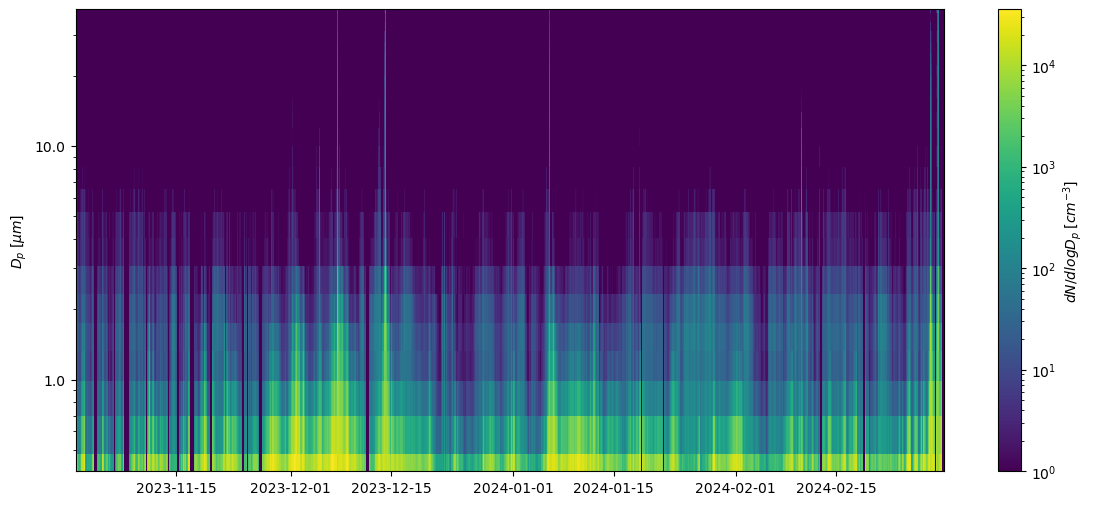

In [13]:
X = obj.dndlogdp.index
Y = obj.midpoints
Z = obj.dndlogdp.T.values

# Plot the data
ax = smps.plots.heatmap(
    X, Y, Z,
    cmap='viridis',
    fig_kws=dict(figsize=(14, 6))
)

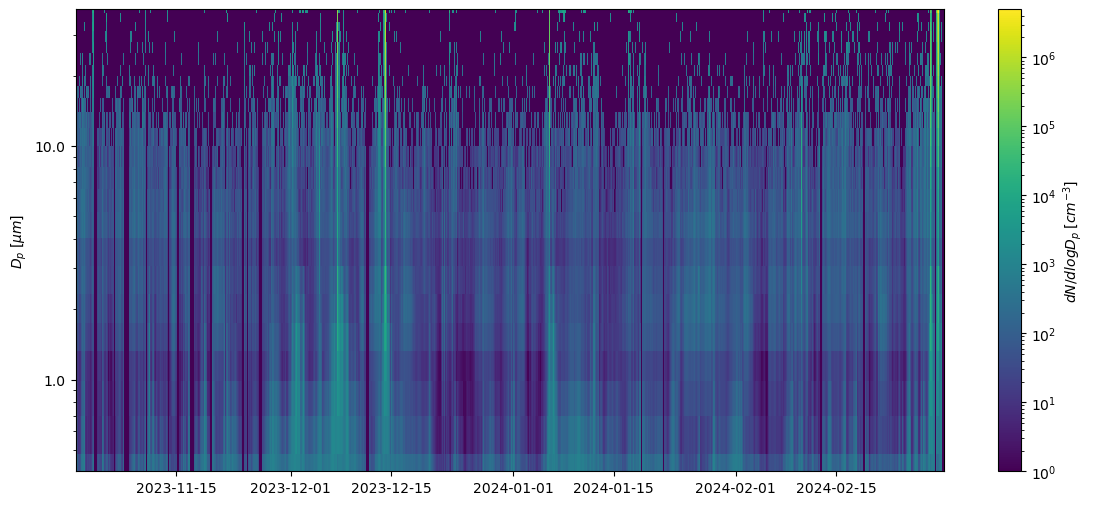

In [14]:
X = obj.dvdlogdp.index
Y = obj.midpoints
Z = obj.dvdlogdp.T.values

# Plot the data
ax = smps.plots.heatmap(
    X, Y, Z,
    cmap='viridis',
    fig_kws=dict(figsize=(14, 6))
)

In [15]:
# Vytvořte seznam unikátních dat ve formátu datetime64[ns]
dates = df.index.unique()

# Ujistěte se, že index je typu DatetimeIndex
obj.dvdlogdp.index = pd.to_datetime(obj.dvdlogdp.index)
print(obj.dvdlogdp.index)

DatetimeIndex(['2023-11-01 01:00:00+00:00', '2023-11-01 02:00:00+00:00',
               '2023-11-01 03:00:00+00:00', '2023-11-01 04:00:00+00:00',
               '2023-11-01 05:00:00+00:00', '2023-11-01 06:00:00+00:00',
               '2023-11-01 07:00:00+00:00', '2023-11-01 08:00:00+00:00',
               '2023-11-01 09:00:00+00:00', '2023-11-01 10:00:00+00:00',
               ...
               '2024-02-29 14:00:00+00:00', '2024-02-29 15:00:00+00:00',
               '2024-02-29 16:00:00+00:00', '2024-02-29 17:00:00+00:00',
               '2024-02-29 18:00:00+00:00', '2024-02-29 19:00:00+00:00',
               '2024-02-29 20:00:00+00:00', '2024-02-29 21:00:00+00:00',
               '2024-02-29 22:00:00+00:00', '2024-02-29 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='GMT', length=2905, freq=None)


In [16]:
# Převzorkujte data na 24hodinové průměry
df_resampled = df.resample('D').mean()

# Vytvořte seznam unikátních dat ve formátu datetime64[ns]
dates = df_resampled.index.unique()
print(dates)

DatetimeIndex(['2023-11-01 00:00:00+00:00', '2023-11-02 00:00:00+00:00',
               '2023-11-03 00:00:00+00:00', '2023-11-04 00:00:00+00:00',
               '2023-11-05 00:00:00+00:00', '2023-11-06 00:00:00+00:00',
               '2023-11-07 00:00:00+00:00', '2023-11-08 00:00:00+00:00',
               '2023-11-09 00:00:00+00:00', '2023-11-10 00:00:00+00:00',
               ...
               '2024-02-20 00:00:00+00:00', '2024-02-21 00:00:00+00:00',
               '2024-02-22 00:00:00+00:00', '2024-02-23 00:00:00+00:00',
               '2024-02-24 00:00:00+00:00', '2024-02-25 00:00:00+00:00',
               '2024-02-26 00:00:00+00:00', '2024-02-27 00:00:00+00:00',
               '2024-02-28 00:00:00+00:00', '2024-02-29 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='GMT', length=121, freq='D')


In [17]:
objd = smps.models.AlphasenseOPCN3(data=df_resampled)
objd.dn.head(3)

,bin0,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9,...,bin14,bin15,bin16,bin17,bin18,bin19,bin20,bin21,bin22,bin23
GMT,,,,,,,,,,,,,,,,,,,,,
2023-11-01 00:00:00+00:00,481.236018,56.295495,11.294389,2.012900,2.194511,1.582902,0.934520,0.382518,0.318491,0.120561,...,0.002289,0.002536,0.000758,0.000631,0.000126,0.000126,0.000509,0.000126,0.000000,0.000000
2023-11-02 00:00:00+00:00,804.176658,187.378090,38.674171,5.842599,4.585007,2.388028,1.269767,0.486821,0.425607,0.181980,...,0.005626,0.003404,0.002756,0.001875,0.001575,0.000116,0.000347,0.000347,0.000116,0.000116
2023-11-03 00:00:00+00:00,506.335984,57.925362,11.117213,2.013913,2.153465,1.429907,0.746503,0.255173,0.191692,0.080114,...,0.009788,0.008163,0.005556,0.005789,0.005676,0.005357,0.003373,0.003175,0.002381,0.007405


In [18]:
pm1d=objd.integrate(weight='mass', dmin=0., dmax=1., rho=1.65)
pm10d=objd.integrate(weight='mass', dmin=0., dmax=10., rho=1.65)
print(pm1d/pm10d)

GMT
2023-11-01 00:00:00+00:00    0.248928
2023-11-02 00:00:00+00:00    0.323485
2023-11-03 00:00:00+00:00    0.295418
2023-11-04 00:00:00+00:00    0.319903
2023-11-05 00:00:00+00:00    0.165228
                               ...   
2024-02-25 00:00:00+00:00    0.508458
2024-02-26 00:00:00+00:00    0.336594
2024-02-27 00:00:00+00:00    0.418377
2024-02-28 00:00:00+00:00    0.194918
2024-02-29 00:00:00+00:00    0.076891
Freq: D, Length: 121, dtype: float64


In [30]:
# Convert the index to datetime
pm1d.index = pd.to_datetime(pm1d.index)

# Print the value for a specific date
date_to_print = '2023-12-08'

print(f"PM1 value for {date_to_print}: {pm1d.loc[date_to_print]}")

# Convert the index to datetime
pm10d.index = pd.to_datetime(pm10d.index)

print(f"PM10 value for {date_to_print}: {pm10d.loc[date_to_print]}")

print(f"PM1/PM10 value for {date_to_print}: {pm1d.loc[date_to_print]/pm10d.loc[date_to_print]}")

ratiod=pm1d.loc[date_to_print]/pm10d.loc[date_to_print]

print(f"ratio value for {date_to_print}: {ratiod}")


PM1 value for 2023-12-08: 710.9199043728538
PM10 value for 2023-12-08: 1409.8018689116277
PM1/PM10 value for 2023-12-08: 0.5042693729166969
ratio value for 2023-12-08: 0.5042693729166969


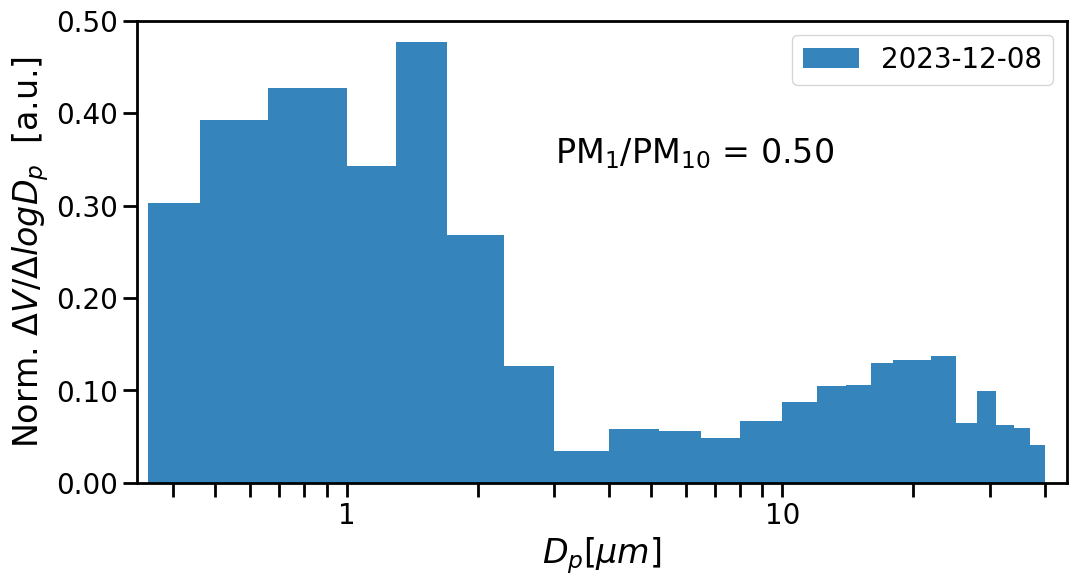

In [42]:
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

# Define the date you want to plot
selected_date = pd.to_datetime("2023-12-08")

# Initialize variables for the plot
cp = itertools.cycle(sns.color_palette())

# Create a single subplot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Ensure the index is of type DatetimeIndex
objd.dvdlogdp.index = pd.to_datetime(objd.dvdlogdp.index)

# Filter data for the selected date
filtered_data = objd.dvdlogdp.loc[objd.dvdlogdp.index.date == selected_date.date()]

# Normalize the y-values
filtered_data_normalized = normalize(filtered_data.values.reshape(1, -1)).flatten()

# Plot the normalized data
smps.plots.histplot(
    filtered_data_normalized,
    objd.bins,
    ax=ax,
    plot_kws=dict(alpha=0.9, color=next(cp), linewidth=0.9)
)

# Set the limits and labels
ax.set_xlim(0.33, 45)  # Set x-axis range
ax.set_ylim(0, 0.5)  # Set y-axis range to [0, 1] for normalized values
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))  # Format y-axis
ax.set_ylabel("Norm. $ΔV/ΔlogD_p \;$ [a.u.]", fontsize=24)  # Use delta symbol for y-axis label
ax.set_xlabel("$D_p [µm]$", fontsize=24)  # Increase font size for x-axis label
ax.legend([selected_date.strftime('%Y-%m-%d')], loc='upper right', fontsize=20)  # Increase font size for legend
ax.tick_params(axis='both', which='major', labelsize=20)  # Increase tick label size
ax.tick_params(axis='x', which='both', length=10, width=2)  # Highlight x-ticks
ax.tick_params(axis='y', which='both', length=10, width=2)  # Highlight y-ticks

# Calculate PM1/PM10 ratio and add text box
ax.text(0.75, 0.75, f'PM$_1$/PM$_{{10}}$ = {ratiod:.2f}', transform=ax.transAxes, fontsize=24,
        verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.0))

# Remove top and right spines and increase border thickness
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Increase border thickness

# Display the plot
plt.show()


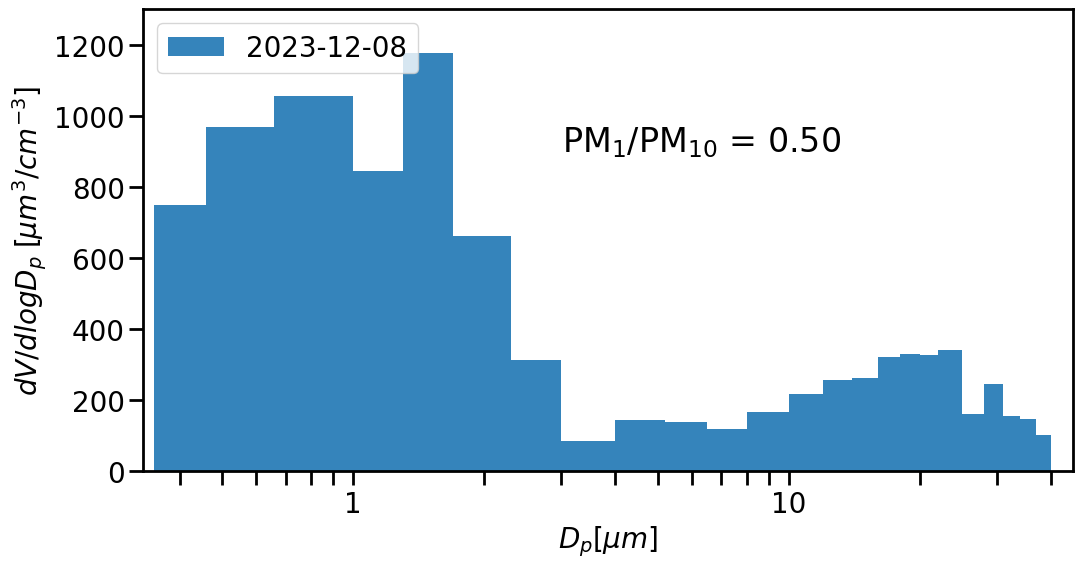

In [34]:
# Define the date you want to plot
selected_date = pd.to_datetime("2023-12-08")

# Initialize variables for the plot
cp = itertools.cycle(sns.color_palette())

# Create a single subplot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Ensure the index is of type DatetimeIndex
objd.dvdlogdp.index = pd.to_datetime(objd.dvdlogdp.index)

# Filter data for the selected date
filtered_data = objd.dvdlogdp.loc[objd.dvdlogdp.index.date == selected_date.date()]

# Plot the data
smps.plots.histplot(
    filtered_data,
    objd.bins,
    ax=ax,
    plot_kws=dict(alpha=0.9, color=next(cp), linewidth=0.9)
)

# Set the limits and labels
ax.set_xlim(0.33, 45)  # Set x-axis range
ax.set_ylim(0, 1300)  # Set y-axis range
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))  # Format y-axis
ax.set_ylabel("$dV/dlogD_p \; [µm^3/cm^{-3}]$", fontsize=20)  # Increase font size for y-axis label
ax.set_xlabel("$D_p [µm]$", fontsize=20)  # Increase font size for x-axis label
ax.legend([selected_date.strftime('%Y-%m-%d')], loc='upper left', fontsize=20)  # Increase font size for legend
ax.tick_params(axis='both', which='major', labelsize=20)  # Increase tick label size
ax.tick_params(axis='x', which='both', length=10, width=2)  # Highlight x-ticks
ax.tick_params(axis='y', which='both', length=10, width=2)  # Highlight y-ticks

# Calculate PM1/PM10 ratio and add text box

ax.text(0.75, 0.75, f'PM$_1$/PM$_{{10}}$ = {ratiod:.2f}', transform=ax.transAxes, fontsize=24,
            verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.0))


# Remove top and right spines and increase border thickness
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Increase border thickness

# Display the plot
plt.show()

In [23]:
# Convert the index to datetime
pm1d.index = pd.to_datetime(pm1d.index)

# Print the value for a specific date
date_to_print = '2024-01-10'

print(f"PM1 value for {date_to_print}: {pm1d.loc[date_to_print]}")

# Convert the index to datetime
pm10d.index = pd.to_datetime(pm10d.index)

print(f"PM10 value for {date_to_print}: {pm10d.loc[date_to_print]}")

print(f"PM1/PM10 value for {date_to_print}: {pm1d.loc[date_to_print]/pm10d.loc[date_to_print]}")

ratiod=pm1d.loc[date_to_print]/pm10d.loc[date_to_print]

print(f"ratio value for {date_to_print}: {ratiod}")


PM1 value for 2024-01-10: 326.287525393709
PM10 value for 2024-01-10: 433.68586939948284
PM1/PM10 value for 2024-01-10: 0.7523591346093743
ratio value for 2024-01-10: 0.7523591346093743


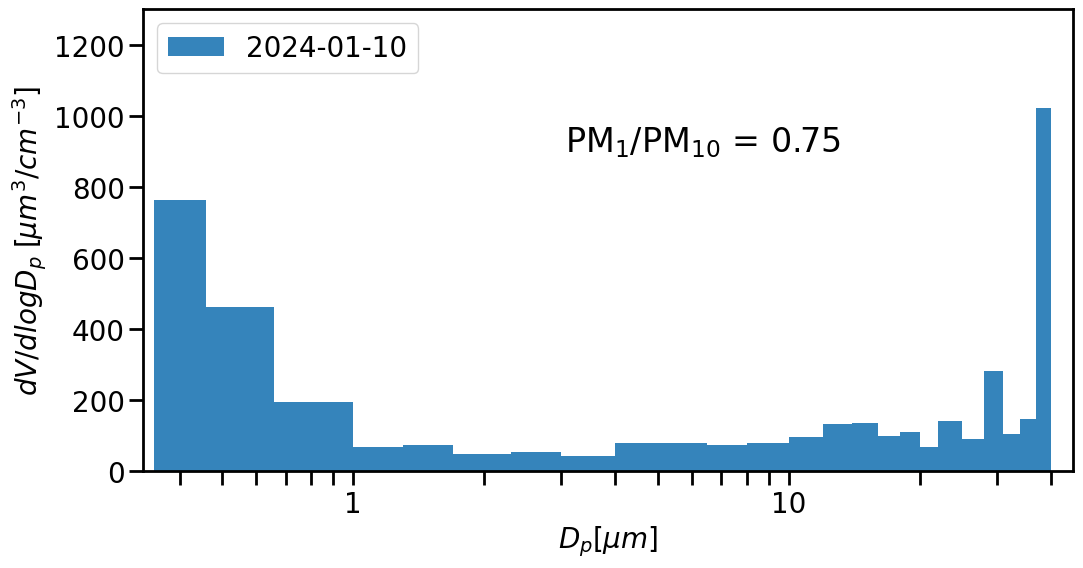

In [24]:
# Define the date you want to plot
selected_date = pd.to_datetime("2024-01-10")

# Initialize variables for the plot
cp = itertools.cycle(sns.color_palette())

# Create a single subplot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Ensure the index is of type DatetimeIndex
objd.dvdlogdp.index = pd.to_datetime(objd.dvdlogdp.index)

# Filter data for the selected date
filtered_data = objd.dvdlogdp.loc[objd.dvdlogdp.index.date == selected_date.date()]

# Plot the data
smps.plots.histplot(
    filtered_data,
    objd.bins,
    ax=ax,
    plot_kws=dict(alpha=0.9, color=next(cp), linewidth=0.9)
)

# Set the limits and labels
ax.set_xlim(0.33, 45)  # Set x-axis range
ax.set_ylim(0, 1300)  # Set y-axis range
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))  # Format y-axis
ax.set_ylabel("$dV/dlogD_p \; [µm^3/cm^{-3}]$", fontsize=20)  # Increase font size for y-axis label
ax.set_xlabel("$D_p [µm]$", fontsize=20)  # Increase font size for x-axis label
ax.legend([selected_date.strftime('%Y-%m-%d')], loc='upper left', fontsize=20)  # Increase font size for legend
ax.tick_params(axis='both', which='major', labelsize=20)  # Increase tick label size
ax.tick_params(axis='x', which='both', length=10, width=2)  # Highlight x-ticks
ax.tick_params(axis='y', which='both', length=10, width=2)  # Highlight y-ticks

# Calculate PM1/PM10 ratio and add text box

ax.text(0.75, 0.75, f'PM$_1$/PM$_{{10}}$ = {ratiod:.2f}', transform=ax.transAxes, fontsize=24,
            verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.0))


# Remove top and right spines and increase border thickness
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Increase border thickness

# Display the plot
plt.show()

In [25]:
# Převzorkujte data na 24hodinové průměry
df_resampled = df.resample('ME').median()

# Vytvořte seznam unikátních dat ve formátu datetime64[ns]
dates = df_resampled.index.unique()
print(dates)

DatetimeIndex(['2023-11-30 00:00:00+00:00', '2023-12-31 00:00:00+00:00',
               '2024-01-31 00:00:00+00:00', '2024-02-29 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='GMT', freq='ME')


In [26]:
objm = smps.models.AlphasenseOPCN3(data=df_resampled)
objm.dn.head(3)

,bin0,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9,...,bin14,bin15,bin16,bin17,bin18,bin19,bin20,bin21,bin22,bin23
GMT,,,,,,,,,,,,,,,,,,,,,
2023-11-30 00:00:00+00:00,505.952778,48.800000,11.159722,2.152778,2.180556,1.381944,0.568056,0.205556,0.164611,0.061438,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-31 00:00:00+00:00,828.213889,123.088889,22.925000,3.211111,2.606340,1.433333,0.494444,0.163889,0.125000,0.041667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-01-31 00:00:00+00:00,685.572009,101.030556,23.125000,3.930556,3.493056,1.840278,0.611111,0.183333,0.138889,0.047222,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
pm1=objm.integrate(weight='mass', dmin=0., dmax=1., rho=1.65)
pm10=objm.integrate(weight='mass', dmin=0., dmax=10., rho=1.65)
print(pm1)
print(pm10)

GMT
2023-11-30 00:00:00+00:00    41.954168
2023-12-31 00:00:00+00:00    77.532341
2024-01-31 00:00:00+00:00    66.097986
2024-02-29 00:00:00+00:00    36.391145
Freq: ME, dtype: float64
GMT
2023-11-30 00:00:00+00:00    118.886153
2023-12-31 00:00:00+00:00    142.000687
2024-01-31 00:00:00+00:00    144.029374
2024-02-29 00:00:00+00:00    139.378230
Freq: ME, dtype: float64


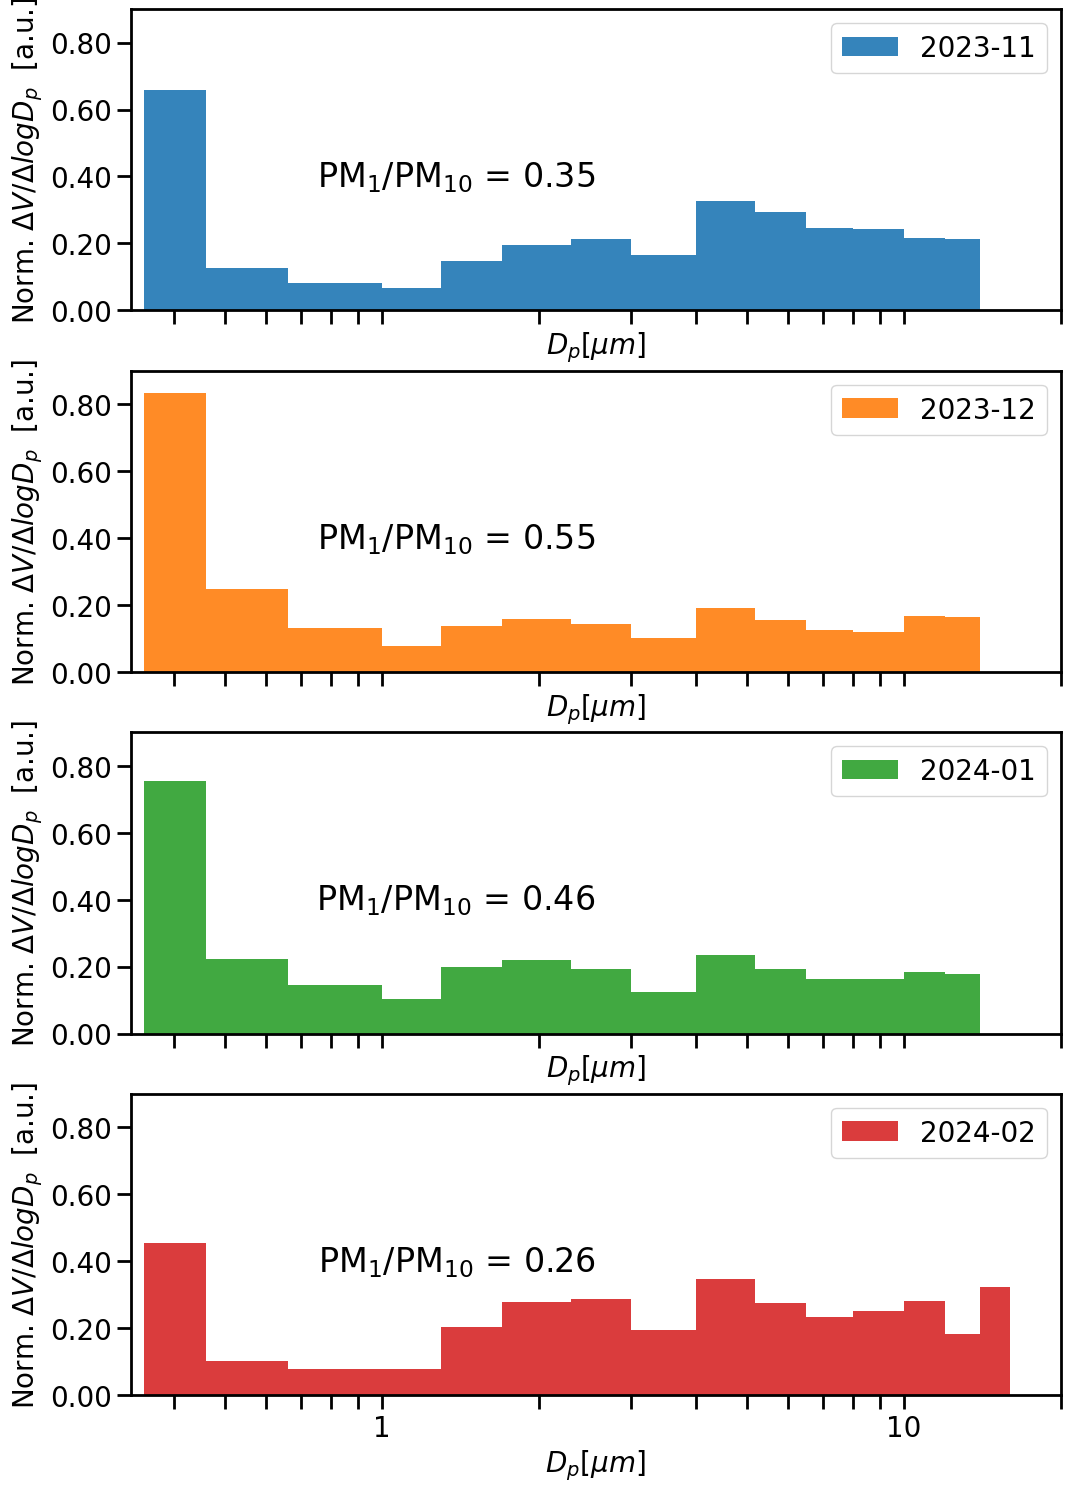

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.preprocessing import normalize

# Example DataFrame with PM1 and PM10 values
data = {
    'date': ["2023-11-30", "2023-12-31", "2024-01-31", "2024-02-29"],
    'pm1': [41.954168, 77.532341, 66.097986, 36.391145],
    'pm10': [118.886153, 142.000687, 144.029374, 139.378230]
}
df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Selected dates
selected_dates = ["2023-11-30", "2023-12-31", "2024-01-31", "2024-02-29"]
selected_dates = pd.to_datetime(selected_dates)

# Initialize variables for the plot
cp = itertools.cycle(sns.color_palette())

# Create subplots
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(12, 18))

# Ensure the index is of type DatetimeIndex
objm.dvdlogdp.index = pd.to_datetime(objm.dvdlogdp.index)

# Create a plot for each selected date
for ax, date in zip(axs, selected_dates):
    filtered_data = objm.dvdlogdp.loc[objm.dvdlogdp.index.date == date.date()]
    
    # Normalize the y-values using scikit-learn
    filtered_data_normalized = normalize(filtered_data.values.reshape(1, -1)).flatten()
    
    # Plot the normalized data
    smps.plots.histplot(
        filtered_data_normalized,
        objm.bins,
        ax=ax,
        plot_kws=dict(alpha=0.9, color=next(cp), linewidth=0.9)
    )
    ax.set_xlim(0.33, 20)  # Set x-axis range
    ax.set_ylim(0, 0.9)  # Set y-axis range to [0, 1.1] for normalized values
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))  # Format y-axis
    ax.set_ylabel("Norm. $ΔV/ΔlogD_p \;$ [a.u.]", fontsize=20)  # Use delta symbol for y-axis label
    ax.set_xlabel("$D_p [µm]$", fontsize=20)  # Increase font size
    ax.legend([date.strftime('%Y-%m')], loc='upper right', fontsize=20)  # Increase legend font size
    ax.tick_params(axis='both', which='major', labelsize=20)  # Increase tick label size
    ax.tick_params(axis='x', which='both', length=10, width=2)  # Highlight x-ticks
    ax.tick_params(axis='y', which='both', length=10, width=2)  # Highlight y-ticks

    # Calculate PM1/PM10 ratio and add text box
    pm1_value = df.loc[date, 'pm1']
    pm10_value = df.loc[date, 'pm10']
    ratio = pm1_value / pm10_value
    ax.text(0.5, 0.5, f'PM$_1$/PM$_{{10}}$ = {ratio:.2f}', transform=ax.transAxes, fontsize=24,
            verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.0))

# Set x-axis label for the last subplot
axs[-1].set_xlabel("$D_p$[$\mu m$]", fontsize=20)  # Increase font size

# Remove top and right spines and increase border thickness
for ax in axs:
    for spine in ax.spines.values():
        spine.set_linewidth(2)  # Increase border thickness

# Show the plot
plt.show()

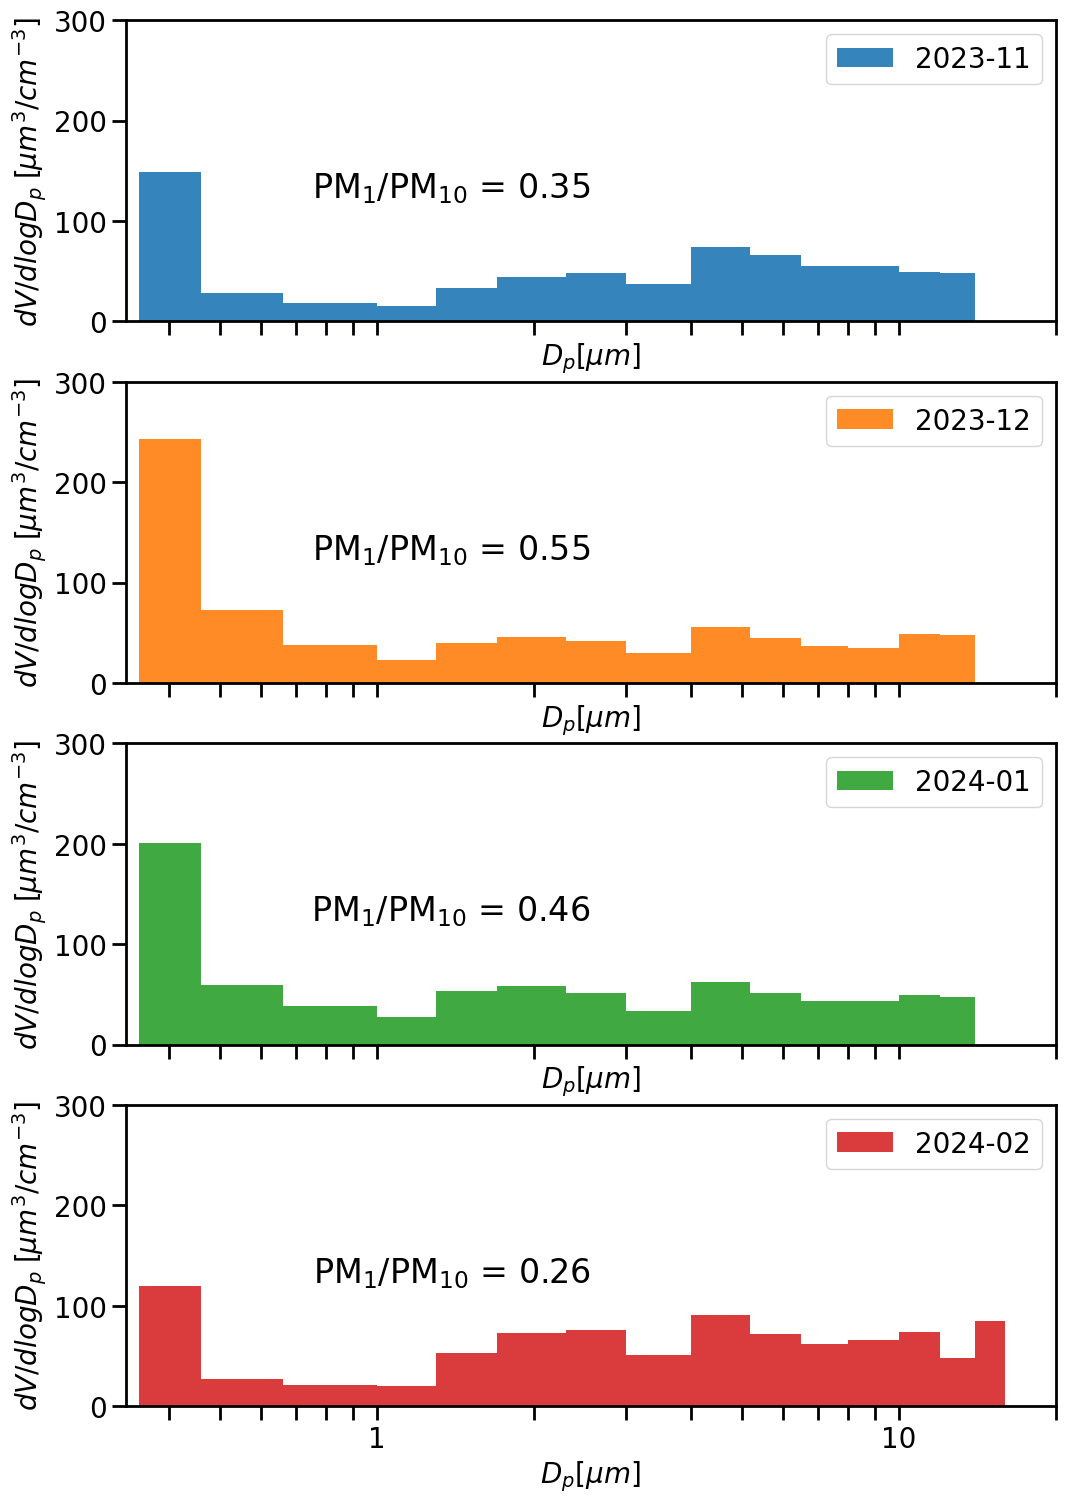

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# Example DataFrame with PM1 and PM10 values
data = {
    'date': ["2023-11-30", "2023-12-31", "2024-01-31", "2024-02-29"],
    'pm1': [41.954168, 77.532341, 66.097986, 36.391145],
    'pm10': [118.886153, 142.000687, 144.029374, 139.378230]
}
df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Selected dates
selected_dates = ["2023-11-30", "2023-12-31", "2024-01-31", "2024-02-29"]
selected_dates = pd.to_datetime(selected_dates)

# Initialize variables for the plot
cp = itertools.cycle(sns.color_palette())

# Create subplots
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(12, 18))

# Ensure the index is of type DatetimeIndex
objm.dvdlogdp.index = pd.to_datetime(objm.dvdlogdp.index)

# Create a plot for each selected date
for ax, date in zip(axs, selected_dates):
    filtered_data = objm.dvdlogdp.loc[objm.dvdlogdp.index.date == date.date()]
    smps.plots.histplot(
        filtered_data,
        objm.bins,
        ax=ax,
        plot_kws=dict(alpha=0.9, color=next(cp), linewidth=0.9)
    )
    ax.set_xlim(0.33, 20)  # Set x-axis range
    ax.set_ylim(0, 300)  # Set y-axis range
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))  # Format y-axis
    ax.set_ylabel("$dV/dlogD_p \; [µm^3/cm^{-3}]$", fontsize=20)  # Increase font size
    ax.set_xlabel("$D_p [µm]$", fontsize=20)  # Increase font size
    ax.legend([date.strftime('%Y-%m')], loc='upper right', fontsize=20)  # Increase legend font size
    ax.tick_params(axis='both', which='major', labelsize=20)  # Increase tick label size
    ax.tick_params(axis='x', which='both', length=10, width=2)  # Highlight x-ticks
    ax.tick_params(axis='y', which='both', length=10, width=2)  # Highlight y-ticks

    # Calculate PM1/PM10 ratio and add text box
    pm1_value = df.loc[date, 'pm1']
    pm10_value = df.loc[date, 'pm10']
    ratio = pm1_value / pm10_value
    ax.text(0.5, 0.5, f'PM$_1$/PM$_{{10}}$ = {ratio:.2f}', transform=ax.transAxes, fontsize=24,
            verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.0))

# Set x-axis label for the last subplot
axs[-1].set_xlabel("$D_p$[$\mu m$]", fontsize=20)  # Increase font size

# Remove top and right spines and increase border thickness
for ax in axs:
    for spine in ax.spines.values():
        spine.set_linewidth(2)  # Increase border thickness

# Show the plot
plt.show()

In [29]:
pm1ref=df_resampled['PM01 [ug/m3]']
pm10ref=df_resampled['PM10 [ug/m3]']
print(pm1ref/pm10ref)

GMT
2023-11-30 00:00:00+00:00   NaN
2023-12-31 00:00:00+00:00   NaN
2024-01-31 00:00:00+00:00   NaN
2024-02-29 00:00:00+00:00   NaN
Freq: ME, dtype: float64
